<h1 align='center'><span class="header-section-number"> </span>Diferenciación Automática con JAX <br/>Introducción</h1>

<h2><span class="header-section-number"> 1 </span> Introducción </h2>

Con su versión actualizada de [Autograd](https://github.com/hips/autograd), [JAX](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html) puede diferenciar automáticamente el código nativo de Python y NumPy. Puede derivarse través de un gran subconjunto de características de Python, incluidos bucles, ifs, recursión y clousures, e incluso puede tomar derivadas de derivadas de derivadas. Admite la diferenciación tanto en modo inverso como en modo directo, y los dos pueden componerse arbitrariamente en cualquier orden.

Lo nuevo es que JAX usa [XLA](https://www.tensorflow.org/xla) para compilar y ejecutar su código NumPy en aceleradores, como GPU y TPU. La compilación ocurre de forma predeterminada, con las llamadas de la biblioteca compiladas y ejecutadas justo a tiempo. Pero JAX incluso le permite compilar justo a tiempo sus propias funciones de Python en núcleos optimizados para XLA utilizando una API de una función. La compilación y la diferenciación automática se pueden componer de forma arbitraria, por lo que puede expresar algoritmos sofisticados y obtener el máximo rendimiento sin tener que abandonar Python.

In [17]:
# !pip install --upgrade jax jaxlib 
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
key = random.PRNGKey(0)

<h2><span class="header-section-number"> 2 </span> Gradientes </h2>

Podemos diferenciar una función con *grad*:

In [2]:
# obtain its gradient function
grad_tanh = grad(np.tanh)
grad_tanh(1.0)

DeviceArray(0.41997433, dtype=float32)

*grad* toma una función y regresa una función. Supongamos que *f* es una función Python que evalua una función matemática. Entonces *grad(f)* es una función Python que evalua $\nabla f$. Así *grad(f)(x)* evalua $\nabla f(x)$.

In [3]:
x = 2.0
print(grad(np.tanh)(x))
print(grad(grad(np.tanh))(x))
print(grad(grad(grad(np.tanh)))(x))

0.070650816
-0.13621867
0.25265405


In [9]:
# vmap vectorize the function
gr_v = vmap(grad(np.tanh))
x = np.array([1.,2.0])
print(gr_v(x))

[0.41997433 0.07065082]


In [10]:
np.tanh(x)

DeviceArray([0.7615942, 0.9640276], dtype=float32)

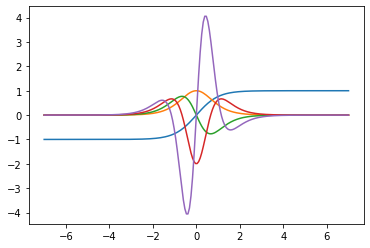

In [25]:
# 
# import elementwise_grad for functions that vectorix¿ze over inputs
from __future__ import absolute_import
import autograd.numpy as onp
from autograd import elementwise_grad as egrad
import matplotlib.pyplot as plt
x = onp.linspace(-7,7,200)
g1 = jit(vmap(grad(np.tanh))) # first derivative
g2 = jit(vmap(grad(grad((np.tanh))))) # second derivative
g3 = jit(vmap(grad(grad(grad((np.tanh)))))) # third derivative
g4 = jit(vmap(grad(grad(grad(grad((np.tanh))))))) # fourth derivative

plt.plot(x, np.tanh(x),
         x, g1(x),
         x, g2(x),
         x, g3(x),
         x, g4(x)
        )

plt.show()

<h2><span class="header-section-number"> 3 </span> Modelo de Regresión Logística desde cero usando grad </h2>

In [27]:
def sigmoid(x):
    return 0.5*(np.tanh(x/2)+1)
# seems more stable than  1.0/(1+np.exp(-x))

# outputs probability of a label being true
def predict(W,b,inputs):
    return sigmoid(np.dot(inputs,W)+b)

# Build a toy dataset
inputs = np.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = np.array([True, True, False, True])

# training loss: -log likelihood of trainig examples
def loss(W,b,x,y):
    preds = predict(W,b,x)
    label_probs = preds*y + (1-preds)*(1-y)
    return -np.sum(np.log(label_probs))

# initialize coefficients
key, W_key, b_key = random.split(key,3)
W = random.normal(key, (3,))
b = random.normal(key,())


Usaremos la funcion *grad* con sus argumentos  para diferenciar la función con respecto a sus parámetros ṕosicionales

In [52]:
# compile with jit
# argsnums define positional params to derive with respect to
grad_loss = jit(grad(loss,argnums=(0,1)))

In [53]:
W_grad, b_grad = grad_loss(W,b,inputs, targets)
print("W_grad = ", W_grad)
print("b_grad = ", b_grad)

W_grad =  [-0.13325673  0.7287398  -1.7607927 ]
b_grad =  0.022453208


## Ejemplo de entrenamiento de un modelo


In [54]:
# train function
def train(W,b,x,y, lr= 0.12):
    gradient = grad_loss(W,b,inputs,targets) 
    W_grad, b_grad = grad_loss(W,b,inputs,targets)
    W -= W_grad*lr
    b -= b_grad*lr
    return(W,b)

In [55]:
#    
weights, biases = [], []
train_loss= []
epochs = 20

train_loss.append(loss(W,b,inputs,targets))

for epoch in range(epochs):
    W,b = train(W,b,inputs, targets)
    weights.append(W)
    biases.append(b)
    losss = loss(W,b,inputs,targets)
    train_loss.append(losss)
    print(f"Epoch {epoch}: train loss {losss}")

Epoch 0: train loss 2.3193581104278564
Epoch 1: train loss 2.01922345161438
Epoch 2: train loss 1.7796587944030762
Epoch 3: train loss 1.5825984477996826
Epoch 4: train loss 1.4183536767959595
Epoch 5: train loss 1.2804994583129883
Epoch 6: train loss 1.1641706228256226
Epoch 7: train loss 1.0654593706130981
Epoch 8: train loss 0.9811764359474182
Epoch 9: train loss 0.9087210297584534
Epoch 10: train loss 0.8459861278533936
Epoch 11: train loss 0.7912724614143372
Epoch 12: train loss 0.7432132959365845
Epoch 13: train loss 0.7007092833518982
Epoch 14: train loss 0.6628734469413757
Epoch 15: train loss 0.628989040851593
Epoch 16: train loss 0.5984709858894348
Epoch 17: train loss 0.5708418488502502
Epoch 18: train loss 0.5457080006599426
Epoch 19: train loss 0.522742509841919


In [60]:
print('weights')
for weight in weights:
    print(weight)
print('biases')
for bias in biases:
    print(bias)

weights
[ 0.5526737  -0.0814647  -0.11806437]
[ 0.55927765 -0.13807121  0.06845167]
[ 0.5614956  -0.17740442  0.2367465 ]
[ 0.561902   -0.2063056   0.39015874]
[ 0.5618833  -0.22850716  0.53068244]
[ 0.5621856  -0.24620296  0.6597552 ]
[ 0.56318307 -0.2607605   0.77857214]
[ 0.56502855 -0.27307138  0.888201  ]
[ 0.5677453 -0.2837374  0.9896157]
[ 0.57128537 -0.29317585  1.0837021 ]
[ 0.5755653  -0.30168238  1.1712576 ]
[ 0.58048826 -0.30947018  1.252992  ]
[ 0.5859567 -0.3166952  1.3295317]
[ 0.59187865 -0.32347307  1.4014258 ]
[ 0.59817106 -0.32989037  1.4691548 ]
[ 0.60476077 -0.33601263  1.5331378 ]
[ 0.61158454 -0.34188995  1.5937407 ]
[ 0.6185881  -0.34756085  1.6512834 ]
[ 0.6257253 -0.3530553  1.706046 ]
[ 0.63295746 -0.3583968   1.7582744 ]
biases
0.8808514
0.8669749
0.8486012
0.8292053
0.81065005
0.7939027
0.7793964
0.7672425
0.7573656
0.74959135
0.7437017
0.7394684
0.73667145
0.73510873
0.7345997
0.73498607
0.7361306
0.7379152
0.74023885
0.7430152


Este API de *grad* tiene una correspondencia directa con la excelente notación en el clásico *Cálculo sobre Variedades* (1965), también utilizado en la Estructura e interpretación de la mecánica clásica* (2015) de Sussman y Wisdom's (2015) y su *Geometría diferencial funcional* (2013). Ambos libros son de acceso abierto. Consulte en particular la sección "Prólogo" de Geometría diferencial funcional para una defensa de esta notación.

Esencialmente, usando los argnums de una función *f* se obtienen derivadas parciales. Por ejemplo graf(f,i) evalua $\partial_i f$. Pro ejemplo $\partial loss/\partial W$ se denota se escribe $\partial_0 loss$ y se escribe con *grad* como

In [71]:
print(grad(loss,0)(W,b,inputs,targets))

[-0.06078603  0.04339207 -0.41592562]


<h2><span class="header-section-number"> 4 </span> Diferenciación con respecto a listas anidadas, tuplas y dicts </h2>

La diferenciación con respecto a los contenedores estándar de Python simplemente funciona, así que use tuplas, listas y dictados (y anidamiento arbitrario) como desee.

In [79]:
def loss2(params_dict,x,y):
    preds = predict(params_dict['W'], params_dict['b'], x)
    label_probs = preds*y + (1-preds)*(1-y)
    return -np.sum(np.log(label_probs))

In [80]:
print(grad(loss2)({'W':W, 'b':b},inputs,targets))

{'W': DeviceArray([-0.06078603,  0.04339207, -0.41592562], dtype=float32), 'b': DeviceArray(-0.02629587, dtype=float32)}


### Calculando el valor de la función y el gradiente con value_and_grad

In [82]:
from jax import value_and_grad
loss_val, Wb_grad = value_and_grad(loss,(0,1))(W,b,inputs, targets)
print('loss value: ', loss_val)
print('gradient value: ', Wb_grad)

loss value:  0.5227425
gradient value:  (DeviceArray([-0.06078603,  0.04339207, -0.41592562], dtype=float32), DeviceArray(-0.02629587, dtype=float32))


In [ ]:
from jax.test_util import check_grads
def loss(W,b):
    preds = predict(W,b,inputs)
    label_probs = preds*targets + (1-preds)*(1-targets)
    return -np.sum(np.log(label_probs))

assert check_grads(loss, (W, b), order=2)  # check up to 2nd order derivatives